## Inference for the Armond model via particle MCMC 

## Fitting models of metaphase kinetochore oscillations to synthetic data

The model used is the model from [Armond et al. (2015, PloS Comp. Biol.)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004607). This is an SDE dependent on hidden states. 
The key equation for this model is as follows, obtained from discretizing the SDE: 

\begin{align}
(X_{t+\Delta t}^1 - X_t^1)/\Delta t = -v_{\sigma_t^1} -\kappa \left( X_t^1 - X_t^2 -L\cos \theta_t  \right) - \alpha X_t^1 + N(0,s^2), \\
(X_{t+\Delta t}^2 - X_t^2)/\Delta t = +v_{\sigma_t^2} -\kappa \left( X_t^2 - X_t^1 +L\cos \theta_t  \right) - \alpha X_t^2 + N(0,s^2),
\end{align}
where $\sigma_1$ and $\sigma_2$ are hidden states taking values in the set $$(\sigma_1, \sigma_2) \in \{ (+,+),(+,-),(-,+),(-,-) \}$$
with switching rates $p_{coh}$ and $p_{icoh}$ between states based on whether $\sigma_1$ and $\sigma$ are the same (incoherent) or not (coherent). 

To fit this model, we use SMC2 which uses a particle filter both for the discrete hidden states and in parameter space nested together. This an alternative to using a traditional Metropolis-Hastings type kernel to explore parameter space with accept-reject decisions based on a particle filter as in particle marginal Metropolis Hastings (PMMH) methods. One of the motivations for SMC2 in this context is that it should require less tuning than the PMMH methods. These methods are implemented via [Libbi](http://libbi.org/), which can make use of the parallel computing architectures on modern machines. 


We can load the library and set things up as follows

In [49]:
using SMC, Random, Plots, Distributions

trueValues = [0.95, 0.3]
th = thetaSimple(4500000, 0.008, 0.025, -0.035, 0.015, trueValues[1], trueValues[2], 0.775, 2.0)
(armondhmmSimple, transll, approxtrans, approxll) = armondModelSimple(th)
hmm = HMM(armondhmmSimple, transll)
x0 = [0, 0.0, 1.0, 0];
y0 = [0.9, 0];

We generate synthetic data from the model and plot to check that this looks as it should.
We can then use this synthetic data to infer known model parameters.

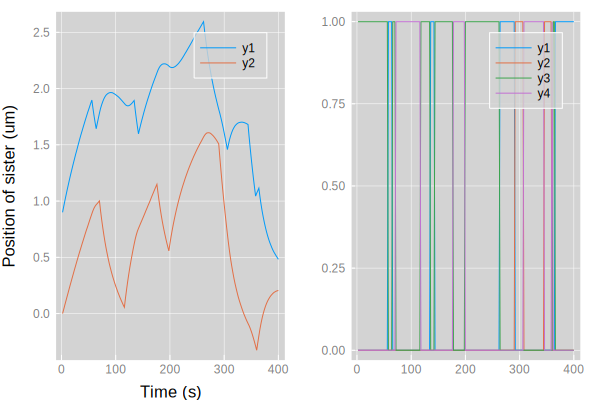

In [50]:
### generation from armond model
Random.seed!(123)
K=200
(states, observations) = generate(armondhmmSimple, x0, y0, K);
p1=plot(th.dt*(1:K), transpose(observations),
    xlabel="Time (s)",
    ylabel="Position of sister (um)")
p2=plot(th.dt*(1:K), transpose(states))
plot(p1,p2)

Now we can specify parameter proposal distributions and run multiple chains of the particle MCMC

In [3]:
using Distributed
addprocs(8)
module_dir = "/Users/jonathanharrison/.julia/dev/SMC.jl"
@everywhere push!(LOAD_PATH, $module_dir) #see https://discourse.julialang.org/t/loading-modules-on-remote-workers-in-julia-1-0-7/13312/3
@everywhere using Distributions, SMC, Random

Random.seed!(125)
dimParams = 2
numRandoms = 2
paramProposal = [x -> TruncatedNormal(x,0.05,0,1),
                 x -> TruncatedNormal(x,0.05,0,1)]
priors = [Beta(2.5,1), Beta(2,1)]
numIter = 1000
nChains = 8
N = 8;

In [4]:
@time out = pmap(x -> correlated(observations, priors,
         paramProposal, dimParams, numRandoms, numIter=numIter, N=N), 1:nChains)


      From worker 3:	Iter: 100
      From worker 3:	acceptance rate is: 0.2
      From worker 2:	Iter: 100
      From worker 2:	acceptance rate is: 0.21
      From worker 5:	Iter: 100
      From worker 4:	Iter: 100
      From worker 8:	Iter: 100
      From worker 7:	Iter: 100
      From worker 9:	Iter: 100
      From worker 5:	acceptance rate is: 0.26
      From worker 4:	acceptance rate is: 0.17
      From worker 6:	Iter: 100
      From worker 8:	acceptance rate is: 0.19
      From worker 7:	acceptance rate is: 0.22
      From worker 9:	acceptance rate is: 0.19
      From worker 6:	acceptance rate is: 0.24
      From worker 3:	Iter: 200
      From worker 3:	acceptance rate is: 0.21
      From worker 2:	Iter: 200
      From worker 2:	acceptance rate is: 0.18
      From worker 5:	Iter: 200
      From worker 5:	acceptance rate is: 0.22
      From worker 8:	Iter: 200
      From worker 8:	acceptance rate is: 0.19
      From worker 4:	Iter: 200
      From worker 4:	acceptance rate is: 0.18


8-element Array{Tuple{LinearAlgebra.Transpose{Float64,Array{Float64,2}},Float64},1}:
 ([0.608016 0.344035; 0.608016 0.344035; … ; 0.512874 0.984779; 0.512874 0.984779], 0.169) 
 ([0.974024 0.637383; 0.956631 0.670133; … ; 0.494172 0.879349; 0.497525 0.820734], 0.175) 
 ([0.896969 0.119741; 0.905614 0.0323311; … ; 0.493865 0.754508; 0.493865 0.754508], 0.178)
 ([0.940387 0.743252; 0.943919 0.709607; … ; 0.500781 0.51764; 0.500781 0.51764], 0.176)   
 ([0.799541 0.907519; 0.757873 0.7767; … ; 0.518907 0.361159; 0.518907 0.361159], 0.184)   
 ([0.87471 0.818603; 0.833885 0.794154; … ; 0.496336 0.649302; 0.496336 0.649302], 0.194)  
 ([0.824201 0.936374; 0.824201 0.936374; … ; 0.523686 0.148286; 0.502777 0.153865], 0.168) 
 ([0.607382 0.731268; 0.607382 0.731268; … ; 0.514701 0.742492; 0.518171 0.820167], 0.188) 

In [5]:
#extracting from output of pmap is a bit messy; https://stackoverflow.com/questions/44234255/return-multiple-values-from-a-mapped-function
cTemp, actRate = map(x->getindex.(out, x), 1:2)
c =  zeros(numIter,dimParams,nChains)
for i=1:nChains
    c[:,:,i] = cTemp[i]
end

We can plot the chains and assess convergence. 


Gelman, Rubin, and Brooks Diagnostic

│ Row │ parameters │ PSRF    │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┤
│ 1   │ Param1     │ 1.01945 │ 1.02494 │
│ 2   │ Param2     │ 1.19066 │ 1.42313 │


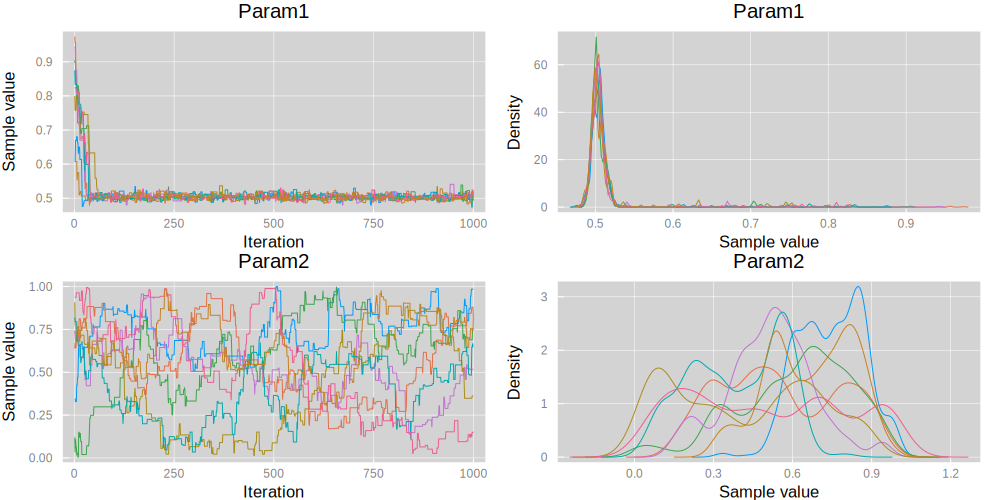

In [7]:
using MCMCChains, StatsPlots
theme(:ggplot2)
chn=Chains(c);
Rhat = gelmandiag(chn)
println(Rhat)

# visualize the MCMC simulation results
p1 = StatsPlots.plot(chn, colordim = :parameter)
p2 = StatsPlots.plot(chn)